# Stability of sentences

TODO: the same with raw word length (not content length)

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr' + os.path.split(os.path.abspath(os.path.curdir))[1][9:]
setup_spreadr(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_2


Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from pandas import DataFrame
from scipy.stats import linregress
import seaborn as sb

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

Equip models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

## 2 Stability of sentences

First generate our data

In [5]:
data = []
order = []
for tree in Tree.objects.experiment.all():
    root = tree.root
    root_length = len(root.content_words)
    order.append({'tree id': tree.id,
                  'root length': root_length})
    for sentence in tree.sentences.kept.all():
        if sentence.parent is None:
            ordered_content_rate = 0.0
            raw_rate = 0.0
            raw_cumrate = 0.0
            ordered_content_cumrate = 0.0
        else:
            ordered_content_rate = sentence.ordered_content_distance(sentence.parent)
            raw_rate = sentence.raw_distance(sentence.parent)
            raw_cumrate = sentence.cum_root_distance('raw')
            ordered_content_cumrate = sentence.cum_root_distance('ordered_content')
        length = len(sentence.content_words)
        data.append({'tree id': tree.id,
                     'sentence id': sentence.id,
                     'length': length,
                     'root length': root_length,
                     'length / len(root)': length / root_length,
                     'diff from root': \
                         root.ordered_content_distance(sentence, normalized=False) / \
                             root_length,
                     'depth': sentence.depth,
                     'raw rate': raw_rate,
                     'ordered content rate': ordered_content_rate,
                     'raw cumrate': raw_cumrate,
                     'ordered content cumrate': ordered_content_cumrate})
data = DataFrame(data)
root_order = DataFrame(order).sort_values(['root length', 'tree id'])

### 2.1 Quick look at the interactions between transformation rate, length, depth

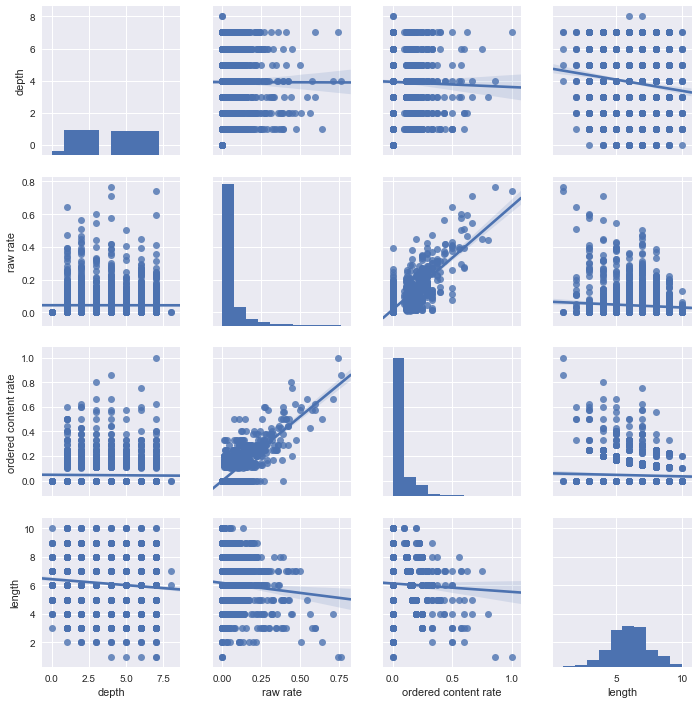

In [6]:
g = sb.pairplot(data=data, vars=['depth', 'raw rate', 'ordered content rate', 'length'], kind='reg')
if SAVE_FIGURES:
    g.savefig(FIG.format('depth_tr_length_interactions'), dpi=300)

### 2.2 At fixed sentence length, how does transformation rate depend on depth?

#### 2.2.1 Non-cumulative transformation rate

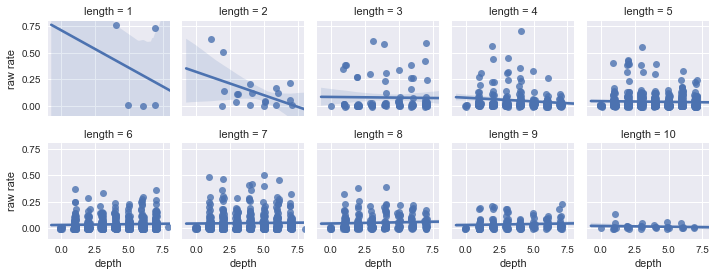

In [7]:
ordered_lengths = sorted(set(data.length.values))
g = sb.lmplot(data=data, x='depth', y='raw rate',
              col='length', col_wrap=5, size=2, col_order=ordered_lengths,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 8), ylim=(-.1, .8))
if SAVE_FIGURES:
    g.savefig(FIG.format('tr-raw_depth_fixed-length'), dpi=300)

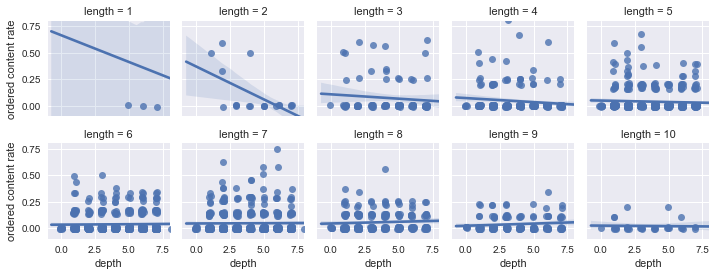

In [8]:
ordered_lengths = sorted(set(data.length.values))
g = sb.lmplot(data=data, x='depth', y='ordered content rate',
              col='length', col_wrap=5, size=2, col_order=ordered_lengths,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 8), ylim=(-.1, .8))
if SAVE_FIGURES:
    g.savefig(FIG.format('tr-ordered-content_depth_fixed-length'), dpi=300)

#### 2.2.2 Cumulative transformation rate

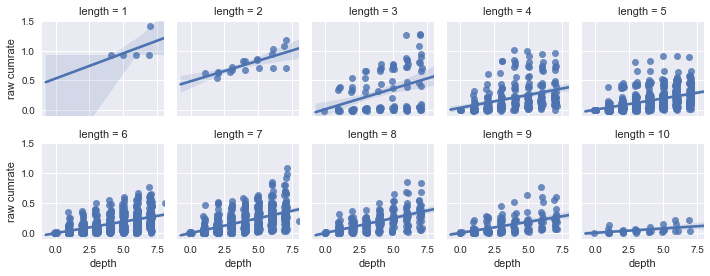

In [9]:
ordered_lengths = sorted(set(data.length.values))
g = sb.lmplot(data=data, x='depth', y='raw cumrate',
              col='length', col_wrap=5, size=2, col_order=ordered_lengths,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 8), ylim=(-.1, 1.5))
if SAVE_FIGURES:
    g.savefig(FIG.format('cumtr-raw_depth_fixed-length'), dpi=300)

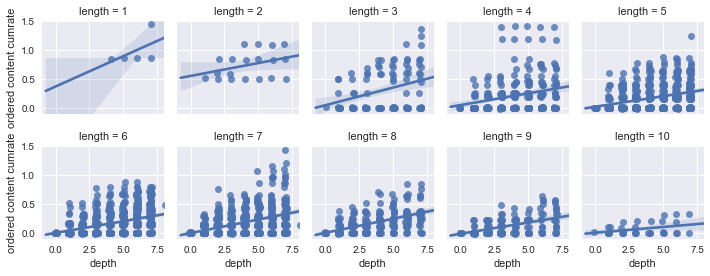

In [10]:
ordered_lengths = sorted(set(data.length.values))
g = sb.lmplot(data=data, x='depth', y='ordered content cumrate',
              col='length', col_wrap=5, size=2, col_order=ordered_lengths,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 8), ylim=(-.1, 1.5))
if SAVE_FIGURES:
    g.savefig(FIG.format('cumtr-ordered-content_depth_fixed-length'), dpi=300)

### 2.3 How do trees behave with transformation rate ~ depth?

#### 2.3.1 Non-cumulative transformation rate

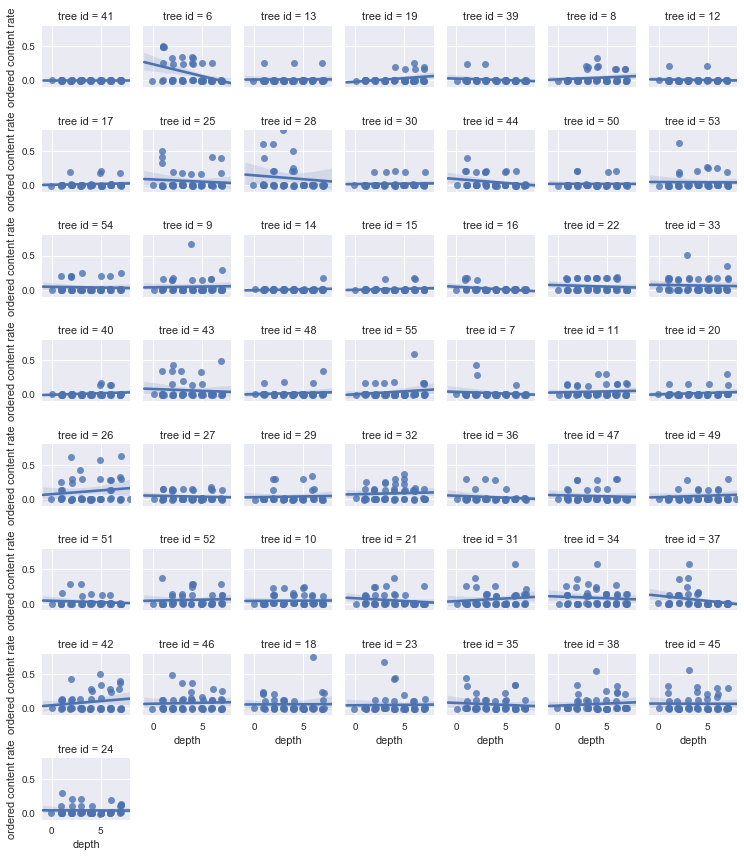

In [11]:
g = sb.lmplot(data=data,
              x='depth', y='ordered content rate',
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'],
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 8), ylim=(-.1, .8))
if SAVE_FIGURES:
    g.savefig(FIG.format('tr_depth'), dpi=300)

#### 2.3.2 Cumulative transformation rate

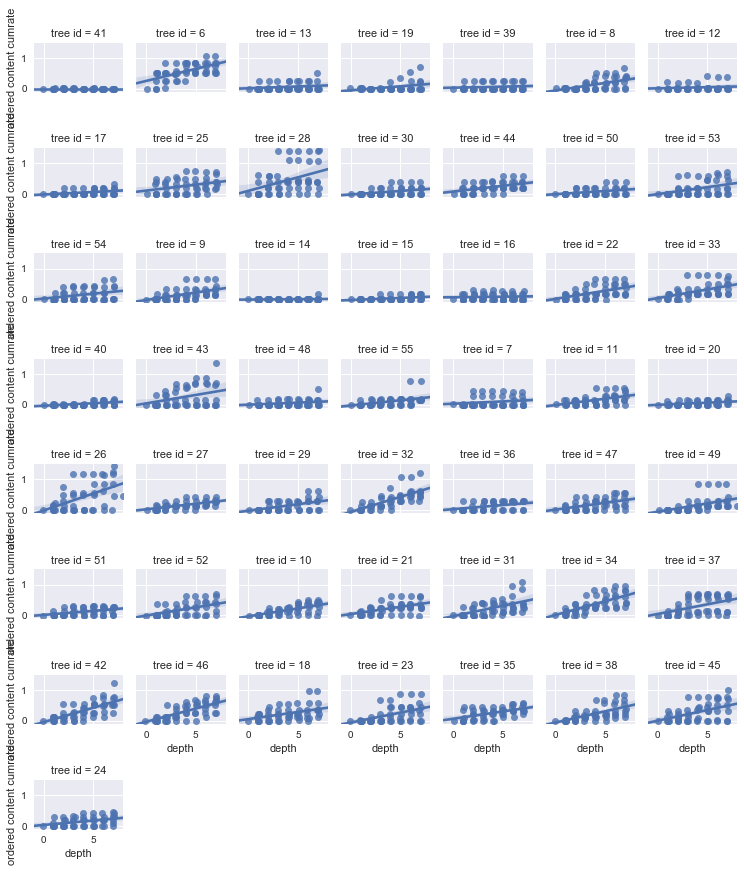

In [12]:
g = sb.lmplot(data=data,
              x='depth', y='ordered content cumrate',
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'],
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 8), ylim=(-.1, 1.5))
if SAVE_FIGURES:
    g.savefig(FIG.format('cumtr_depth'), dpi=300)

### 2.4 How do trees behave with length ~ depth?

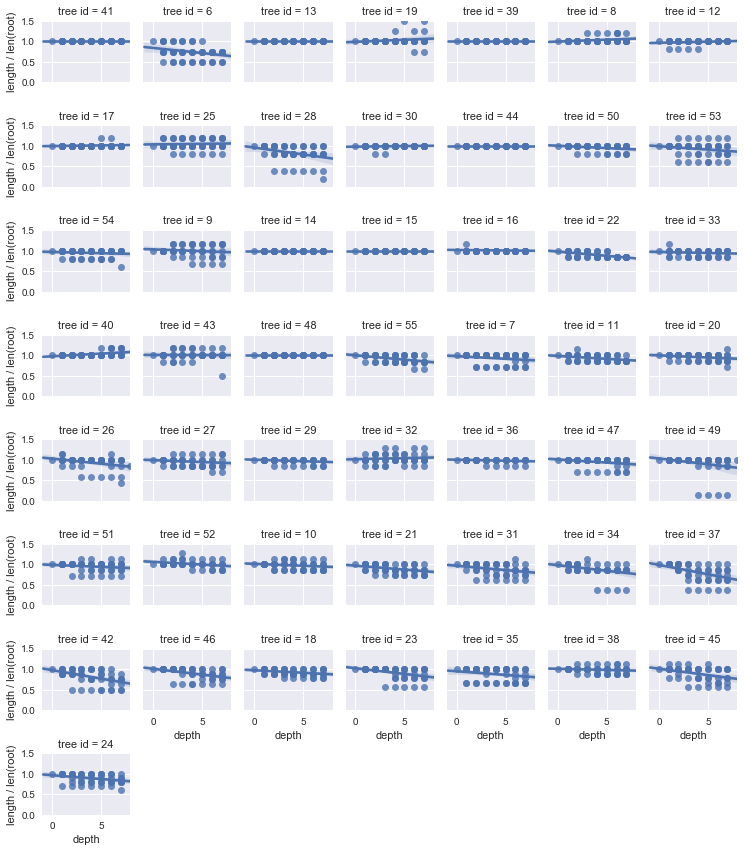

In [13]:
g = sb.lmplot(data=data,
              x='depth', y='length / len(root)',
              sharex=True, sharey=True,
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-1, 8), ylim=(0, 1.5))
if SAVE_FIGURES:
    g.savefig(FIG.format('length_depth'), dpi=300)

### 2.5 How do trees behave with difference from root ~ depth?

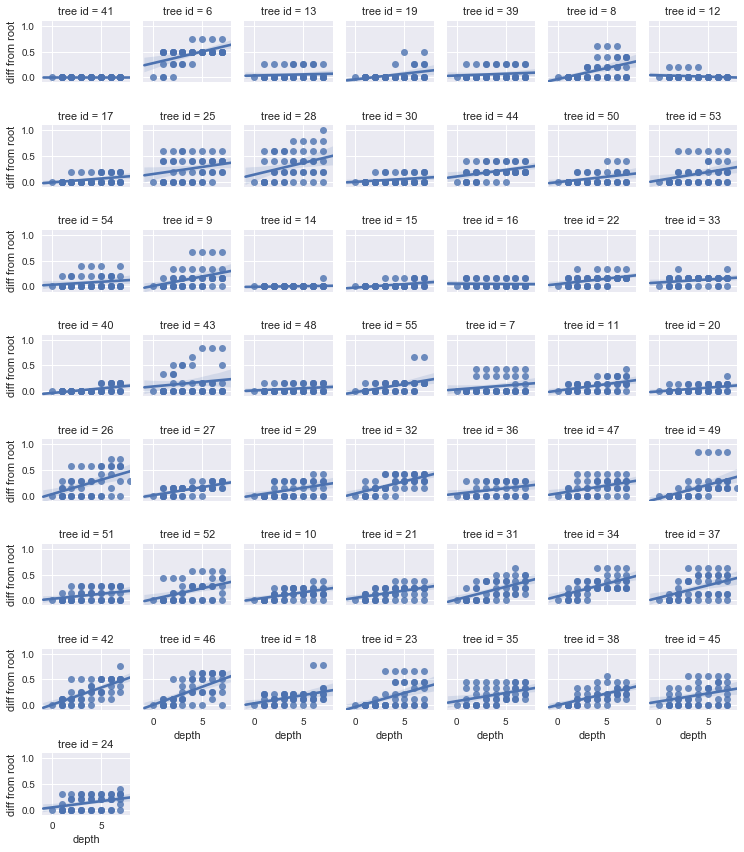

In [14]:
g = sb.lmplot(data=data,
              x='depth', y='diff from root',
              sharex=True, sharey=True,
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-1, 8), ylim=(-.1, 1.1))
if SAVE_FIGURES:
    g.savefig(FIG.format('diffroot_depth'), dpi=300)